__Purpose__: Contains the main models to predict the number of daily trips which occur on a given route

# Prepare Data

In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('all_trips.csv')

_all-trips.csv_ was generated from the _"pipeline"_ function in _"DataPipeline.ipynb"_

In [3]:
data['Day'] = pd.to_datetime(data['Date']).dt.day

In [4]:
data

,TRIP_KEY,Start_ids,End_ids,Start_station,Start_cluster,End_station,End_cluster,Date,AVG_Duration,Month,Weekday,trips,Day
0,0,31253,31037,19th & K St NW,8,Ballston Metro / Stuart St & 9th St N,1,2019-01-01,0.0,1,Tuesday,0.0,1
1,1,31253,31034,19th & K St NW,8,Fairfax Dr & N Randolph St,1,2019-01-01,0.0,1,Tuesday,0.0,1
2,2,31253,31249,19th & K St NW,8,Jefferson Memorial,6,2019-01-01,0.0,1,Tuesday,0.0,1
3,3,31253,31803,19th & K St NW,8,Good Hope Rd & 14th St SE,1,2019-01-01,0.0,1,Tuesday,0.0,1
4,4,31253,31038,19th & K St NW,8,Glebe Rd & 11th St N,4,2019-01-01,0.0,1,Tuesday,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9496195,20820,31646,32093,Maine Ave & 9th St SW,8,White Oak Transit Center,2,2020-03-31,0.0,3,Tuesday,0.0,31
9496196,20821,31646,31926,Maine Ave & 9th St SW,8,Wilson Blvd. & N. Vermont St.,2,2020-03-31,0.0,3,Tuesday,0.0,31
9496197,20822,31646,31826,Maine Ave & 9th St SW,8,Minnesota Ave & R St SE,5,2020-03-31,0.0,3,Tuesday,0.0,31
9496198,20823,31646,32236,Maine Ave & 9th St SW,8,Vy Reston Heights,4,2020-03-31,0.0,3,Tuesday,0.0,31


In [5]:
data_2019 = data[data['Date'].str.startswith('2019')]

In [6]:
data_2020 = data[data['Date'].str.startswith('2020')]

In [7]:
np.mean(data['trips'])

0.03904730313177903

# Plotting the distribution of the data

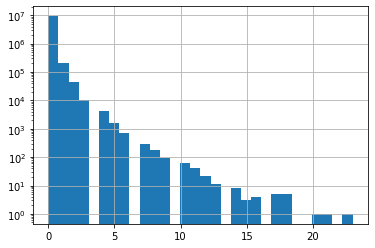

In [8]:
data['trips'].hist(bins = 30, log = True)

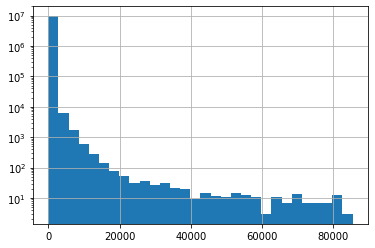

In [9]:
data['AVG_Duration'].hist(bins = 30, log = True)

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough",
            ["AVG_Duration"]),
        ("onehot_categorical", OneHotEncoder(),
            ["End_cluster", "Month", "Weekday", "Day"])
    ],
    remainder="drop"
)

# Make the models

### Dummy Regressor
Predicts the mean value for all input

In [11]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline

dummy = Pipeline([
    ("preprocessor", model_preprocessor),
    ("regressor", DummyRegressor(strategy='mean')),
]).fit(data_2019, data_2019['trips'],
       #regressor__sample_weight=data_2019["AVG_Duration"]
      )

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance

def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(data_2020)

    print("MSE: %.3f" %
          mean_squared_error(data_2020['trips'], y_pred,
                             #data_2020["AVG_Duration"]
                            ))
    print("MAE: %.3f" %
          mean_absolute_error(data_2020['trips'], y_pred,
                              #data_2020["AVG_Duration"]
                             ))

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    
    print("mean Poisson deviance: %.3f" %
          mean_poisson_deviance(data_2020['trips'][mask],
                                y_pred[mask],
                                #sample_weight=data_2020["AVG_Duration"][mask]
                               ))


print("Constant mean frequency evaluation:")
score_estimator(dummy, data_2020)

Constant mean frequency evaluation:
MSE: 0.037
MAE: 0.066
mean Poisson deviance: 0.206


### Ridge Regression

In [14]:
from sklearn.linear_model import Ridge


ridge_glm = Pipeline([
    ("preprocessor", model_preprocessor),
    ("regressor", Ridge(alpha=1e-6)),
]).fit(data_2019, data_2019['trips'],
       #regressor__sample_weight=data_2019["AVG_Duration"]
      )

print("Ridge evaluation:")
score_estimator(ridge_glm, data_2020)

Ridge evaluation:
MSE: 0.029
MAE: 0.052
mean Poisson deviance: 0.114


### Poisson Regression

In [15]:
from sklearn.linear_model import PoissonRegressor

poisson_glm = Pipeline([
    ("preprocessor", model_preprocessor),
    ("regressor", PoissonRegressor(alpha=1e-6, max_iter=100))
])
poisson_glm.fit(data_2019, data_2019['trips'],
       #regressor__sample_weight=data_2019["AVG_Duration"]
               )

print("PoissonRegressor evaluation:")
score_estimator(poisson_glm, data_2020)

PoissonRegressor evaluation:
MSE: 0.037
MAE: 0.066
mean Poisson deviance: 0.206


### Random Forest

In [25]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor

tree_preprocessor = ColumnTransformer(
    [
        ("categorical", OrdinalEncoder(),
            ["End_cluster", "Month", "Weekday", "Day"]),
        ("numeric", "passthrough",
            ["AVG_Duration"]),
    ],
    remainder="drop",
)

rf = Pipeline([
    ("preprocessor", tree_preprocessor),
    ("regressor", RandomForestRegressor(n_jobs = -1)),
])
rf.fit(data_2019, data_2019["trips"],
                 #regressor__sample_weight=data_2019['AVG_Duration']
                )

print("RandomForestRegressor evaluation:")
score_estimator(rf, data_2020)

RandomForestRegressor evaluation:
MSE: 0.008
MAE: 0.008
mean Poisson deviance: 0.220


### Histogram-based Gradient Boosting Regression Tree

In [26]:
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor

poisson_gbrt = Pipeline([
    ("preprocessor", tree_preprocessor),
    ("regressor", HistGradientBoostingRegressor(loss="poisson",
                                                max_leaf_nodes=128)),
])
poisson_gbrt.fit(data_2019, data_2019["trips"],
                 #regressor__sample_weight=data_2019['AVG_Duration']
                )

print("Poisson Gradient Boosted Trees evaluation:")
score_estimator(poisson_gbrt, data_2020)

Poisson Gradient Boosted Trees evaluation:
MSE: 0.007
MAE: 0.007
mean Poisson deviance: 0.004


# Evaluate Model performance
tested on data from January & February & March 2020

In [27]:
import matplotlib.pyplot as plt

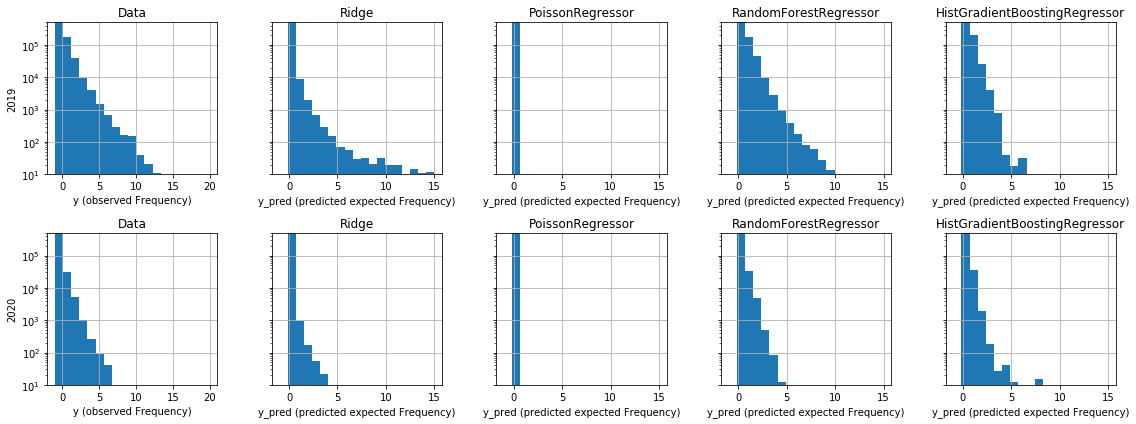

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 6), sharey=True)
fig.subplots_adjust(bottom=0.2)
n_bins = 20
for row_idx, label, df in zip(range(2),
                              ["2019", "2020"],
                              [data_2019, data_2020]):
    
    df['trips'].hist(bins=np.linspace(-1, 20, n_bins),
                         ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_yscale('log')
    axes[row_idx, 0].set_xlabel("y (observed Frequency)")
    axes[row_idx, 0].set_ylim([1e1, 5e5])
    axes[row_idx, 0].set_ylabel(label)

    for idx, model in enumerate([ridge_glm, poisson_glm, rf, poisson_gbrt]):
        y_pred = model.predict(df)

        pd.Series(y_pred).hist(bins=np.linspace(-1, 15, n_bins),
                               ax=axes[row_idx, idx+1])
        axes[row_idx, idx + 1].set(
            title=model[-1].__class__.__name__,
            yscale='log',
            xlabel="y_pred (predicted expected Frequency)"
        )
plt.tight_layout()